In [1]:
from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)  # Disable verbose tqdm output

# Explore-Then-Commit (ETC) Algorithm

See Chapter 6 in [Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)

The ETC algorithm first plays each arm a fixed number of times and then exploits by committing to the best arm.

At round t, the ETC algorithm chooses an action as:

$A_{t}=\left\{\begin{array}{ll}(t \bmod k)+1, & \text { if } t \leq m k \\ \operatorname{argmax}_{i} \hat{\mu}_{i}(m k), & t>m k\end{array}\right.$,

where 
* $m$ is the # of round the algorithm explores. The optimal $m$ is $m^*=\max \left\{1,\lceil\frac{4}{\Delta^{2}} \log \left(\frac{n \Delta^{2}}{4}\right)\rceil\right\}$.
* $k$ is the # of actions 
* $\hat{\mu}_{i}(t)=\frac{1}{T_{i}(t)} \sum_{s=1}^{t} \mathbb{I}\left\{A_{s}=i\right\} X_{s}$ is the average reward received from arm $i$ after round $t$.

With any 1-subgaussian bandit, the ETC algorithm with $m^*$ has the following regret bound (see Eq.(6.6)):

$R_{n} \leq \min \left\{n \Delta, \Delta+\frac{4}{\Delta}\left(1+\max \left\{0, \log \left(\frac{n \Delta^{2}}{4}\right)\right\}\right)\right\}$,

where 
* $\Delta$ is the suboptimality gap 
* $n$ is the horizon.

In [2]:
import numpy as np
from shinrl import GaussianBandit 
from shinrl import ExploreThenCommitSolver as EtcSolver

In [5]:
n_step = 1000
env = GaussianBandit(np.zeros(2), np.ones(2))
config = EtcSolver.DefaultConfig()
mixins = EtcSolver.make_mixins(env, config)
solver = EtcSolver.factory(env, config, mixins)


def calc_regret(gap, m, n_eval=50):
    env.rew_mean = np.array([0.0, -gap])
    config = EtcSolver.DefaultConfig(verbose=False, steps_per_epoch=n_step, explore_round=m, add_interval=1)
    
    regret = 0
    for seed in range(n_eval):
        config.seed = seed
        solver.initialize(env, config)
        solver.run()
        regret += solver.scalars["Regret"]["y"][-1]
    return regret / n_eval

2022-01-04T23:08:46.504084Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 1000, 'verbose': True, 'explore_round': 10} env_id=None solver_id=MixedSolver-2
2022-01-04T23:08:46.504598Z set_env is called.             env_id=0 solver_id=MixedSolver-2
2022-01-04T23:08:46.506235Z Solver is initialized.         env_id=0 methods=['BaseSolver.__init__', 'ExploreThenCommitSolver.act', 'History.add_scalar', 'BanditEvalMixIn.evaluate', 'History.init_history', 'BanditEvalMixIn.initialize', 'History.load', 'ExploreThenCommitSolver.make_mixins', 'History.recent_summary', 'BaseSolver.run', 'History.save', 'BaseSolver.seed', 'History.set_config', 'BaseSolver.set_env', 'ExploreThenCommitSolver.step', 'BanditEvalMixIn.update_regret'] mixins=[<class 'shinrl.solvers.bandit.base_mixin.BanditEvalMixIn'>, <class 'shinrl.solvers.bandit.explore_then_commit_solver.ExploreThenCommitSolver'>] solver_id=MixedSolver

In [10]:
from collections import defaultdict
gaps = np.linspace(0.001, 1.0, 20)
regrets = defaultdict(list)

for gap in gaps:
    print(f"Evaluating regrets of: gap=={gap}")
    m = max(1, np.ceil(4 / (gap ** 2) * np.log(n_step * (gap ** 2) / 4)))  # See Eq.(6.5)
    regrets["optimal"].append(calc_regret(gap, m))
    for m in [25, 50, 75, 100]:
        regrets[m].append(calc_regret(gap, m))

Evaluating regrets of: gap==0.001


/home/rl-dqn/miniconda3/envs/shinrl-jax/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Evaluating regrets of: gap==0.05357894736842105
Evaluating regrets of: gap==0.1061578947368421
Evaluating regrets of: gap==0.15873684210526315
Evaluating regrets of: gap==0.2113157894736842
Evaluating regrets of: gap==0.26389473684210524
Evaluating regrets of: gap==0.3164736842105263
Evaluating regrets of: gap==0.36905263157894735
Evaluating regrets of: gap==0.4216315789473684
Evaluating regrets of: gap==0.47421052631578947
Evaluating regrets of: gap==0.5267894736842105
Evaluating regrets of: gap==0.5793684210526315
Evaluating regrets of: gap==0.6319473684210526
Evaluating regrets of: gap==0.6845263157894736
Evaluating regrets of: gap==0.7371052631578947
Evaluating regrets of: gap==0.7896842105263158
Evaluating regrets of: gap==0.8422631578947368
Evaluating regrets of: gap==0.8948421052631579
Evaluating regrets of: gap==0.9474210526315789
Evaluating regrets of: gap==1.0


In [11]:
upper_bound = np.minimum(n_step * gaps, gaps + 4 / gaps * (1 + np.maximum(0, np.log(n_step * (gaps ** 2) / 4))))

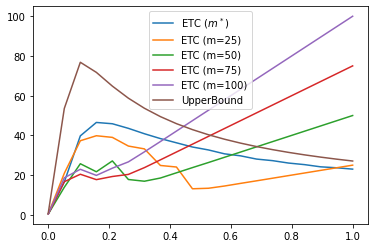

In [12]:
import matplotlib.pyplot as plt

plt.plot(gaps, regrets["optimal"], label="ETC ($m^*$)")
for m in [25, 50, 75, 100]:
    plt.plot(gaps, regrets[m], label=f"ETC (m={m})")
plt.plot(gaps, upper_bound, label="UpperBound")
plt.legend()

**Note:**
The optimal $m^*$ depends on both the suboptimality gap $\delta$ and the horizon $n$.
While the horizon is sometimes known in advance, it is seldom reasonable to assume the knowledge of the suboptimality gap.
On the other hand, the Upper Confidence Bound algorithm does not depend on the advanced knowledge of the gap and even the horizon.